In [1]:
import os
from copy import deepcopy
from inspect import signature
from typing import List, Optional, Union

import numpy as np
import pandas as pd
import xgboost as xgb
import catboost as cb
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders.cat_boost import CatBoostEncoder

## Загрузка данных

In [2]:
data = pd.read_csv("../data/assignment2_data/assignment_2_train.csv")
test = pd.read_csv("../data/assignment2_data/assignment_2_test.csv")
print("data.shape = {} rows, {} cols".format(*data.shape))
data.head(n=2)

data.shape = 180000 rows, 394 cols


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Отбор данных

In [18]:
target = data["isFraud"]
data = data.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1)

numerical_features = data.select_dtypes(include=np.number).columns
categorical_featuers = data.select_dtypes(include=["object"]).columns
data[categorical_featuers] = data[categorical_featuers].astype(str)

In [19]:
x_train, x_valid = train_test_split(
    data, train_size=0.75, random_state=27
)
y_train, y_valid = train_test_split(
    target, train_size=0.75, random_state=27
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

models = {}
train_scores = pd.DataFrame({"target": y_train}) 
valid_scores = pd.DataFrame({"target": y_valid})

x_train.shape = 135000 rows, 391 cols
x_valid.shape = 45000 rows, 391 cols


## Постановка задачи

В домашнем задании, будем обучать разные алгоритмы машинного обучения. Для этого, нужно предварительно зафиксировать схему валидации решения (можете выбрать любую, которую знаете). Выбранную схему валидации нужно использовать во всех задачах этого домашнего задания. Метрика качества - __ROC AUC__, целевая переменная - __isFraud__.

__Задание 1:__ отобрать только числовые признаки и обучить модель `XGBoost` с параметром `booster = gbtree`.  Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

__Задание 2:__ выполнить задание 1, но с параметром `booster = gblinear`. Как изменилось качество, при использовании градиетного бустинга над решающими деревьями и при использовании бустинга над линейными моделями?

__Задание 3:__ обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 1.

__Задание 4:__ обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 2. 

__Задание 5:__ для числовых признаков обучить модель `LightGBM`. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

__Задание 6:__ обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 1. Выполнить задание 5.

__Задание 7:__ обработать категориальные признаки встроенным методом в `LightGBM`. Выполнить задание 5. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 6.

__Задание 8:__ для числовых признаков обучить модель `CatBoost`. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

__Задание 9:__ обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 1. Выполнить задание 8.

__Задание 10:__ обработать категориальные признаки встроенным методом в `CatBoost`. Выполнить задание 5. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 9.

__Задание 11:__ построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.

## 1. XGBoost на числовых признаках

In [19]:
xgb_params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "n_estimators": 1000,
    "learning_rate": 0.1,
    "reg_lambda": 10,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}


eval_sets = [
    (x_train[numerical_features], y_train),
    (x_valid[numerical_features], y_valid)
]
xgb_model = xgb.XGBClassifier(**xgb_params)

In [21]:
xgb_model.fit(
    y=y_train,
    X=x_train[numerical_features],
    early_stopping_rounds=50,
    eval_set=eval_sets,
    eval_metric="auc",
    verbose=10
)
models["XGBoost_gbtree_num_features"] = xgb_model

[0]	validation_0-auc:0.706509	validation_1-auc:0.697254
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[10]	validation_0-auc:0.804072	validation_1-auc:0.797071
[20]	validation_0-auc:0.844029	validation_1-auc:0.836457
[30]	validation_0-auc:0.873514	validation_1-auc:0.865142
[40]	validation_0-auc:0.887063	validation_1-auc:0.878523
[50]	validation_0-auc:0.897561	validation_1-auc:0.886404
[60]	validation_0-auc:0.903828	validation_1-auc:0.891578
[70]	validation_0-auc:0.908573	validation_1-auc:0.895276
[80]	validation_0-auc:0.912478	validation_1-auc:0.898128
[90]	validation_0-auc:0.915343	validation_1-auc:0.90099
[100]	validation_0-auc:0.917832	validation_1-auc:0.90317
[110]	validation_0-auc:0.919105	validation_1-auc:0.904491
[120]	validation_0-auc:0.920508	validation_1-auc:0.905493
[130]	validation_0-auc:0.920715	validation_1-auc:0.905675
[140]	validation_0-auc:0.920715	validation_1

In [12]:
train_scores["XGBoost_gbtree_num_features"] = xgb_model.predict_proba(x_train[numerical_features])[:,1]
valid_scores["XGBoost_gbtree_num_features"] = xgb_model.predict_proba(x_valid[numerical_features])[:,1]

## 2. XGBoost с категориальными признаками

In [20]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """
    Обработка категориальных признаков и подготовка матрицы
    признаков для передачи в любой алгоритм машинного обучения.

    Parameters
    ----------
    encoder: callable
        Объект для обработки категориальных признаков;
        объект должен поддерживать sklearn-API.

    categorical_features: List[str]
        Список с названием категориальных признаков.

    na_value: float or str, optional, default = None
        Значение для заполнения пропусков.
        Опциональный параметр, по умолчанию, не используется.

    """
    def __init__(self,
                 encoder: callable,
                 categorical_features: List[str],
                 na_value: Union[int, float, str] = None) -> None:
        self.encoder = encoder
        self.categorical_features = categorical_features
        self.na_value = na_value

        sig = signature(encoder.fit)
        self.nparams = len(sig.parameters)
        self.encoders = None

    def _prepare_data(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Подготовка данных для передачи в модель.

        """
        if self.na_value:
            return X[self.categorical_features].fillna(self.na_value)

        return X

    def _check_unique_values(self, y: pd.Series) -> pd.Series:
        """
        Проверка на ранее не встречающиеся значения признака.
        Если значения встречаются - заменяем на self.na_value,
        если self.na_value - не задан, то заменяем на моду.

        """
        encoder = self.encoders[y.name]
        missed_values = list(
            set(y.unique()) - set(encoder.classes_)
        )

        if missed_values:
            mask = y.isin(missed_values)
            if self.na_value:
                y[mask] = self.na_value
            else:
                mode = y.value_counts()[0].index
                y[mask] = mode

        return y

    def _fit_label_encoder(self, X: pd.DataFrame) -> None:
        """
        Обучение LabelEncoder'ов для всех признаков;

        """
        self.encoders = {}
        for feature in self.categorical_features:
            x = X[feature].astype(str)
            encoder = deepcopy(self.encoder)
            self.encoders[feature] = encoder.fit(x)

        return self

    def _transform_label_encoder(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Применение LabelEncoder'ов для всех признаков;

        """
        for feature in self.categorical_features:
            x = X[feature].astype(str)
            x = self._check_unique_values(x)
            encoder = self.encoders.get(feature)
            X[feature] = encoder.transform(x)

        return X

    def fit(self, X, y=None):
        """
        Обучение encoder'а категориальных признаков.

        Parameters
        ----------
        X: pandas.core.frame.DataFrame
            Матрица признаков.

        y: pandas.core.frame.Series
            Вектор целевой переменной.
            Опциональный параметр, по умолчанию, не требуется.

        Returns
        -------
        self
        """
        X = self._prepare_data(X)
        if self.nparams == 1:
            self._fit_label_encoder(X=X)
        else:
            self.encoder.fit(
                X[self.categorical_features].astype(str), y
            )
        return self

    def transform(self, X, y=None):
        """
        Преобразование категориальных признаков.

        Parameters
        ----------
        X: pandas.core.frame.DataFrame
            Матрица признаков.

        Returns
        -------
        X_transformed: pandas.core.frame.DataFrame
            Преобразованная матрица признаков с
            обработанными категориальными признаками.

        """
        X = self._prepare_data(X)
        if self.encoders:
            categorical = self._transform_label_encoder(X)
        else:
            categorical = self.encoder.transform(
                X[self.categorical_features].astype(str)
            )

        X = X.drop(self.categorical_features, axis=1)
        X = pd.concat([X, categorical], axis=1)

        return X

## 2.1. XGBoost + CatBoostCategoricalEncoder

In [6]:
encoder = CategoricalEncoder(
    encoder=CatBoostEncoder(random_state=27),
    categorical_features=categorical_featuers,
)

x_train_catboost_encoder = encoder.fit_transform(x_train, y_train)
x_valid_catboost_encoder = encoder.transform(x_valid)

In [7]:
eval_sets = [
    (x_train_catboost_encoder, y_train),
    (x_valid_catboost_encoder, y_valid)
]

xgb_model.fit(
    y=y_train,
    X=x_train_catboost_encoder,
    early_stopping_rounds=50,
    eval_set=eval_sets,
    eval_metric="auc",
    verbose=10
)
models["XGBoost_gbtree_catboost_encoder"] = xgb_model

NameError: name 'xgb_model' is not defined

In [36]:
train_scores["XGBoost_gbtree_catboost_encoder"] = xgb_model.predict_proba(
    x_train_catboost_encoder)[:,1]
valid_scores["XGBoost_gbtree_catboost_encoder"] = xgb_model.predict_proba(
    x_valid_catboost_encoder)[:,1]

## 2.2. XGBoost + OneHotEncoder

In [107]:
x_train_ohe = pd.get_dummies(
    x_train[categorical_featuers], columns=categorical_featuers
)
x_valid_ohe = pd.get_dummies(
    x_valid[categorical_featuers], columns=categorical_featuers
)
x_valid_ohe = x_valid_ohe.reindex(columns=x_train_ohe.columns)

x_train_ohe_encoder = pd.concat([
    x_train[numerical_features], x_train_ohe], axis=1
)
x_valid_ohe_encoder = pd.concat([
    x_valid[numerical_features], x_valid_ohe], axis=1
)

In [108]:
eval_sets = [
    (x_train_ohe_encoder, y_train),
    (x_valid_ohe_encoder, y_valid)
]

xgb_model.fit(
    y=y_train,
    X=x_train_ohe_encoder,
    early_stopping_rounds=50,
    eval_set=eval_sets,
    eval_metric="auc",
    verbose=10
)

[0]	validation_0-auc:0.706509	validation_1-auc:0.697254
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[10]	validation_0-auc:0.807886	validation_1-auc:0.800477
[20]	validation_0-auc:0.843041	validation_1-auc:0.835527
[30]	validation_0-auc:0.870595	validation_1-auc:0.862247
[40]	validation_0-auc:0.884633	validation_1-auc:0.876194
[50]	validation_0-auc:0.894683	validation_1-auc:0.884799
[60]	validation_0-auc:0.901864	validation_1-auc:0.890458
[70]	validation_0-auc:0.906359	validation_1-auc:0.893893
[80]	validation_0-auc:0.910546	validation_1-auc:0.89762
[90]	validation_0-auc:0.912418	validation_1-auc:0.899283
[100]	validation_0-auc:0.914827	validation_1-auc:0.901427
[110]	validation_0-auc:0.917371	validation_1-auc:0.903978
[120]	validation_0-auc:0.918866	validation_1-auc:0.905011
[130]	validation_0-auc:0.920156	validation_1-auc:0.906217
[140]	validation_0-auc:0.920809	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=6, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=1, seed=27,
              silent=None, subsample=1, verbosity=1)

In [109]:
train_scores["XGBoost_gbtree_ohe"] = xgb_model.predict_proba(
    x_train_ohe_encoder)[:,1]
valid_scores["XGBoost_gbtree_ohe"] = xgb_model.predict_proba(
    x_valid_ohe_encoder)[:,1]

## 2.3. XGBoost + LabelEncoder

In [79]:
encoder = CategoricalEncoder(
    encoder=LabelEncoder(),
    categorical_features=categorical_featuers,
    na_value=-99999
)

x_train_label_encoder = encoder.fit_transform(x_train)
x_valid_label_encoder = encoder.transform(x_valid)

In [80]:
x_train_label_encoder = pd.concat([
    x_train[numerical_features], x_train_label_encoder], axis=1
)
x_valid_label_encoder = pd.concat([
    x_valid[numerical_features], x_valid_label_encoder], axis=1
)

In [81]:
eval_sets = [
    (x_train_label_encoder, y_train),
    (x_valid_label_encoder, y_valid)
]

xgb_model.fit(
    y=y_train,
    X=x_train_label_encoder,
    early_stopping_rounds=50,
    eval_set=eval_sets,
    eval_metric="auc",
    verbose=10
)

[0]	validation_0-auc:0.706509	validation_1-auc:0.697254
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[10]	validation_0-auc:0.807815	validation_1-auc:0.800377
[20]	validation_0-auc:0.843981	validation_1-auc:0.83624
[30]	validation_0-auc:0.868316	validation_1-auc:0.860621
[40]	validation_0-auc:0.881995	validation_1-auc:0.872685
[50]	validation_0-auc:0.891156	validation_1-auc:0.88066
[60]	validation_0-auc:0.897506	validation_1-auc:0.887122
[70]	validation_0-auc:0.901831	validation_1-auc:0.890314
[80]	validation_0-auc:0.906171	validation_1-auc:0.893881
[90]	validation_0-auc:0.908198	validation_1-auc:0.895461
[100]	validation_0-auc:0.910215	validation_1-auc:0.897
[110]	validation_0-auc:0.912808	validation_1-auc:0.898514
[120]	validation_0-auc:0.914139	validation_1-auc:0.899898
[130]	validation_0-auc:0.915745	validation_1-auc:0.901312
[140]	validation_0-auc:0.917622	validation_1-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=6, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=1, seed=27,
              silent=None, subsample=1, verbosity=1)

In [82]:
train_scores["XGBoost_gbtree_label_encoder"] = xgb_model.predict_proba(
    x_train_label_encoder)[:,1]
valid_scores["XGBoost_gbtree_label_encoder"] = xgb_model.predict_proba(
    x_valid_label_encoder)[:,1]

## 3. CatBoost на числовых признаках

In [8]:
cb_params = {
    "n_estimators": 2000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    #"max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

eval_sets = [
    (x_train[numerical_features], y_train),
    (x_valid[numerical_features], y_valid)
]

In [9]:
cb_model = cb.CatBoostClassifier(**cb_params)
cb_model.fit(x_train[numerical_features], y_train, eval_set=eval_sets)

0:	test: 0.6837546	test1: 0.6815317	best: 0.6815317 (0)	total: 151ms	remaining: 5m 1s
10:	test: 0.7899894	test1: 0.7813562	best: 0.7813562 (10)	total: 711ms	remaining: 2m 8s
20:	test: 0.8178704	test1: 0.8075417	best: 0.8075417 (20)	total: 1.33s	remaining: 2m 5s
30:	test: 0.8440305	test1: 0.8389085	best: 0.8389085 (30)	total: 1.9s	remaining: 2m
40:	test: 0.8513049	test1: 0.8452713	best: 0.8452713 (40)	total: 2.45s	remaining: 1m 57s
50:	test: 0.8547116	test1: 0.8484729	best: 0.8484729 (50)	total: 3.06s	remaining: 1m 56s
60:	test: 0.8556007	test1: 0.8483709	best: 0.8490016 (52)	total: 3.63s	remaining: 1m 55s
70:	test: 0.8576740	test1: 0.8502392	best: 0.8502460 (69)	total: 4.21s	remaining: 1m 54s
80:	test: 0.8595789	test1: 0.8517025	best: 0.8517909 (79)	total: 4.83s	remaining: 1m 54s
90:	test: 0.8608686	test1: 0.8528300	best: 0.8528300 (90)	total: 5.48s	remaining: 1m 55s
100:	test: 0.8624706	test1: 0.8542412	best: 0.8543252 (99)	total: 6.11s	remaining: 1m 54s
110:	test: 0.8638362	test1: 0.

In [10]:
train_scores["CatBoost_num_features"] = cb_model.predict_proba(x_train[numerical_features])[:,1]
valid_scores["CatBoost_num_features"] = cb_model.predict_proba(x_valid[numerical_features])[:,1]

In [14]:
y_pred = cb_model.predict_proba(test[numerical_features])[:, 1]
score = roc_auc_score(test["isFraud"], y_pred)
score

0.860027494949436

## 3.1. CatBoost с категориальными признаками

In [21]:
eval_sets = [
    (x_train, y_train),
    (x_valid, y_valid)
]

cb_model.fit(
    x_train,
    y_train,
    cat_features=categorical_featuers,
    eval_set=eval_sets)

0:	test: 0.6837526	test1: 0.6744405	best: 0.6744405 (0)	total: 327ms	remaining: 10m 53s
10:	test: 0.8045297	test1: 0.8027523	best: 0.8027523 (10)	total: 2.84s	remaining: 8m 33s
20:	test: 0.8255879	test1: 0.8205697	best: 0.8205697 (20)	total: 5.06s	remaining: 7m 56s
30:	test: 0.8376844	test1: 0.8313245	best: 0.8313245 (30)	total: 7.01s	remaining: 7m 25s
40:	test: 0.8462773	test1: 0.8393527	best: 0.8393527 (40)	total: 9.08s	remaining: 7m 13s
50:	test: 0.8502781	test1: 0.8437651	best: 0.8437651 (50)	total: 11.1s	remaining: 7m 3s
60:	test: 0.8549872	test1: 0.8482681	best: 0.8483503 (58)	total: 13.1s	remaining: 6m 56s
70:	test: 0.8599434	test1: 0.8525536	best: 0.8525536 (70)	total: 15.1s	remaining: 6m 51s
80:	test: 0.8629483	test1: 0.8553567	best: 0.8553567 (80)	total: 17.2s	remaining: 6m 47s
90:	test: 0.8639178	test1: 0.8557337	best: 0.8558256 (88)	total: 19.2s	remaining: 6m 42s
100:	test: 0.8662895	test1: 0.8579360	best: 0.8579360 (100)	total: 21.2s	remaining: 6m 39s
110:	test: 0.8681544	

In [22]:
train_scores["CatBoost_all_features"] = cb_model.predict_proba(x_train)[:,1]
valid_scores["CatBoost_all_features"] = cb_model.predict_proba(x_valid)[:,1]

## 3.2. CatBoost с OneHotEncoding

In [113]:
eval_sets = [
    (x_train_ohe_encoder, y_train),
    (x_valid_ohe_encoder, y_valid)
]

cb_model.fit(
    x_train_ohe_encoder,
    y_train,
    eval_set=eval_sets)

0:	test: 0.6812681	test1: 0.6638260	best: 0.6638260 (0)	total: 61.9ms	remaining: 2m 3s
10:	test: 0.7881231	test1: 0.7757121	best: 0.7757121 (10)	total: 717ms	remaining: 2m 9s
20:	test: 0.8084659	test1: 0.8006340	best: 0.8006340 (20)	total: 1.43s	remaining: 2m 14s
30:	test: 0.8379107	test1: 0.8330601	best: 0.8330601 (30)	total: 2.1s	remaining: 2m 13s
40:	test: 0.8483623	test1: 0.8416517	best: 0.8416517 (40)	total: 2.87s	remaining: 2m 16s
50:	test: 0.8524868	test1: 0.8448139	best: 0.8448139 (50)	total: 3.61s	remaining: 2m 17s
60:	test: 0.8559900	test1: 0.8471063	best: 0.8474593 (59)	total: 4.44s	remaining: 2m 21s
70:	test: 0.8582070	test1: 0.8495153	best: 0.8495153 (70)	total: 5.2s	remaining: 2m 21s
80:	test: 0.8627946	test1: 0.8549197	best: 0.8549197 (80)	total: 5.9s	remaining: 2m 19s
90:	test: 0.8651825	test1: 0.8567384	best: 0.8567384 (90)	total: 6.63s	remaining: 2m 19s
100:	test: 0.8670299	test1: 0.8592582	best: 0.8592582 (100)	total: 7.29s	remaining: 2m 17s
110:	test: 0.8684870	test

In [114]:
train_scores["CatBoost_ohe_features"] = cb_model.predict_proba(x_train_ohe_encoder)[:,1]
valid_scores["CatBoost_ohe_features"] = cb_model.predict_proba(x_valid_ohe_encoder)[:,1]

## 3.3. CatBoost с LabelEncoder

In [117]:
eval_sets = [
    (x_train_label_encoder, y_train),
    (x_valid_label_encoder, y_valid)
]

cb_model.fit(
    x_train_label_encoder,
    y_train,
    eval_set=eval_sets)

0:	test: 0.6673582	test1: 0.6563277	best: 0.6563277 (0)	total: 75.3ms	remaining: 2m 30s
10:	test: 0.8063883	test1: 0.8029175	best: 0.8029175 (10)	total: 811ms	remaining: 2m 26s
20:	test: 0.8198217	test1: 0.8155367	best: 0.8155367 (20)	total: 1.47s	remaining: 2m 18s
30:	test: 0.8405115	test1: 0.8366261	best: 0.8366261 (30)	total: 2.17s	remaining: 2m 18s
40:	test: 0.8516091	test1: 0.8481680	best: 0.8481680 (40)	total: 2.86s	remaining: 2m 16s
50:	test: 0.8546849	test1: 0.8498500	best: 0.8498500 (50)	total: 3.53s	remaining: 2m 14s
60:	test: 0.8551866	test1: 0.8499683	best: 0.8499683 (60)	total: 4.2s	remaining: 2m 13s
70:	test: 0.8578106	test1: 0.8528226	best: 0.8528226 (70)	total: 4.83s	remaining: 2m 11s
80:	test: 0.8620128	test1: 0.8555441	best: 0.8555441 (80)	total: 5.54s	remaining: 2m 11s
90:	test: 0.8638829	test1: 0.8573399	best: 0.8574580 (88)	total: 6.2s	remaining: 2m 9s
100:	test: 0.8665930	test1: 0.8598790	best: 0.8598790 (100)	total: 6.87s	remaining: 2m 9s
110:	test: 0.8675527	tes

In [118]:
train_scores["CatBoost_label_features"] = cb_model.predict_proba(x_train_label_encoder)[:,1]
valid_scores["CatBoost_label_features"] = cb_model.predict_proba(x_valid_label_encoder)[:,1]

## Визуализация полученных результатов

In [119]:
def plot_curves(valid_score: pd.DataFrame, train_scores: pd.DataFrame) -> None:
    """
    Построение ROC-Curve для множества построенных моделей.

    Parameters
    ----------
    valid_scores: pandas.core.frame.DataFrame
        Датафрем с прогнозами модели на валидационной выборке.

    train_scores: pandas.core.frame.DataFrame
        Датафрейм с прогнозами модели на обучающей выборке.

    """
    fig = plt.figure(figsize=(15, 5))
    columns = set(valid_scores.columns) - set(["target"])

    plt.subplot(121)
    plt.xlabel("FPR", size=14)
    plt.ylabel("TPR", size=14)
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    for feature in columns:
        fpr, tpr, _ = roc_curve(
            train_scores["target"], train_scores[feature]
        )
        plt.plot(fpr, tpr, linewidth=2, label=feature)

    plt.legend(loc="best")

    plt.subplot(122)
    plt.xlabel("FPR", size=14)
    plt.ylabel("TPR", size=14)
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    for feature in columns:
        fpr, tpr, _ = roc_curve(
            valid_scores["target"], valid_scores[feature]
        )
        plt.plot(fpr, tpr, linewidth=2, label=feature)
    plt.legend(loc="best")

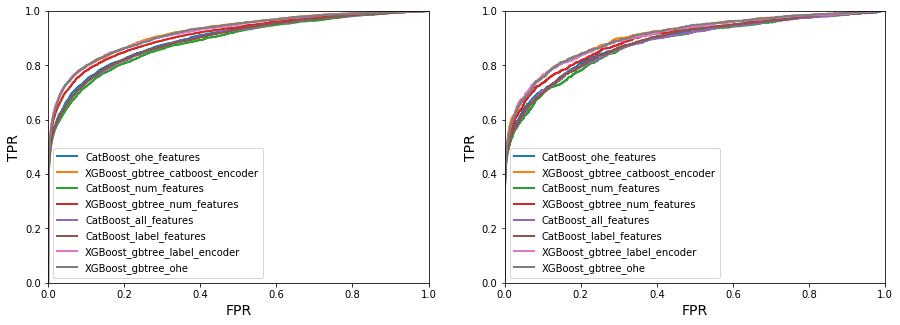

In [120]:
plot_curves(valid_scores, train_scores)